In [ ]:
#importing required libraries and packages

import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
#import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

In [ ]:
#printing out versions of all packages and libraries and used

print(f'pandas version is: {pd.__version__}')
print(f'numpy version is: {np.__version__}')
print(f'matplotlib version is: {matplotlib.__version__}')
print(f'sklearn version is: {sklearn.__version__}')
print(f'xgboost version is: {xgb.__version__}')

pandas version is: 2.1.4
numpy version is: 1.26.4
matplotlib version is: 3.8.0
sklearn version is: 1.2.2
xgboost version is: 2.1.3


In [ ]:
import xgboost
from xgboost import XGBClassifier

print("Version:", xgboost.__version__)
print("XGBClassifier from:", XGBClassifier.__module__)
print("xgboost module path:", xgboost.__file__)

Version: 2.1.3
XGBClassifier from: xgboost.sklearn
xgboost module path: C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\__init__.py


In [ ]:
#all helper functions used

def drop_columns(data, *args):

    '''
    function used to drop columns.
    args::
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''

    columns = []
    for _ in args:
        columns.append(_)

    data = data.drop(columns, axis=1)

    return data

def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args::
      data:  dataframe to be operated on

    returns dataframe with replaced values
    '''

    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])

    return data

def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):

    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

# Feature gradient computation function
def augment_features_gradient(X, depth):

    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff

    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))

    return X_grad

# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):

    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)

    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])

    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#should be edited to the present working directory of the user
#PWD = '/content/drive/My Drive/FORCE-Lithology-Prediction/'

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

In [ ]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(base_dir / 'penalty_matrix.npy')

train = pd.read_csv(base_dir / 'train.csv', sep=';')

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
class Model():

    '''
    class to lithology prediction
    '''

    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''

        self.train = train
        self.test = test


    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values

        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''



        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)

        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')

        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)

        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')

        return traindata1, testdata1, lithology1, lithology_numbers


    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))

      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9,
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500, early_stopping_rounds=100)


      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]

        model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        i+=1

        open_test += model.predict_proba(pd.DataFrame(testdata1))

      open_test= pd.DataFrame(open_test/split)

      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')


      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers


    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)

      #path = PWD

      test = pd.read_csv(base_dir /'hidden_test.csv', sep=';')

      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1292908, 29)
shape of dataframe after dropping columns (1292908, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1292908, 27)
Splitting concatenated dataframe into training and test datasets...
(1292908, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (122397, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (122397, 92))


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:36:36] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16250
[99]	validation_0-mlogloss:0.32182
Default score: [-0.28471641]
Accuracy is: 0.891962546560503
F1 is: 0.8960340144622925
None
-----------------------FOLD 1---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:38:15] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16210
[99]	validation_0-mlogloss:0.32031
Default score: [-0.27707687]
Accuracy is: 0.8946014984921102
F1 is: 0.8984345818566801
None
-----------------------FOLD 2---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:40:23] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16185
[99]	validation_0-mlogloss:0.31645
Default score: [-0.27546753]
Accuracy is: 0.8950542925733227
F1 is: 0.8988741283841036
None
-----------------------FOLD 3---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:28] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16208
[99]	validation_0-mlogloss:0.31751
Default score: [-0.27562024]
Accuracy is: 0.8952678746871022
F1 is: 0.8990796436352255
None
-----------------------FOLD 4---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:44:11] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16189
[99]	validation_0-mlogloss:0.31839
Default score: [-0.27533297]
Accuracy is: 0.8950115761505668
F1 is: 0.8988277840946618
None
-----------------------FOLD 5---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:09] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16183
[99]	validation_0-mlogloss:0.31803
Default score: [-0.27697756]
Accuracy is: 0.8946869313376221
F1 is: 0.8986918258628515
None
-----------------------FOLD 6---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:05] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16218
[99]	validation_0-mlogloss:0.31631
Default score: [-0.27607624]
Accuracy is: 0.8949090567359527
F1 is: 0.8988450522320431
None
-----------------------FOLD 7---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:50:02] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16282
[99]	validation_0-mlogloss:0.32016
Default score: [-0.27891261]
Accuracy is: 0.8945673253539056
F1 is: 0.8985572339318374
None
-----------------------FOLD 8---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:05] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16187
[99]	validation_0-mlogloss:0.31656
Default score: [-0.27886562]
Accuracy is: 0.8944050029474332
F1 is: 0.8984302725410461
None
-----------------------FOLD 9---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:54:06] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16150
[99]	validation_0-mlogloss:0.31417
Default score: [-0.27388275]
Accuracy is: 0.8956523224919052
F1 is: 0.899400586629196
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


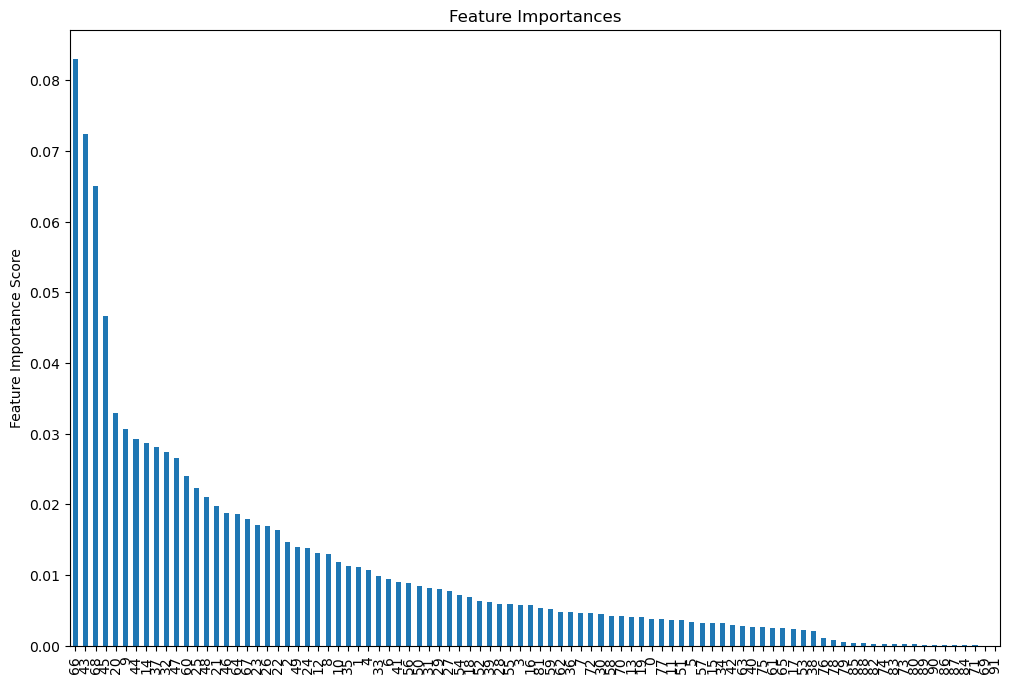

In [ ]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [ ]:
prediction

array([2, 2, 2, ..., 1, 1, 2], dtype=int64)

In [ ]:
len(prediction)

122397

In [ ]:
from pathlib import Path
import numpy as np

lithology_numbers = {30000: 0,
                65030: 1,
                65000: 2,
                80000: 3,
                74000: 4,
                70000: 5,
                70032: 6,
                88000: 7,
                86000: 8,
                99000: 9,
                90000: 10,
                93000: 11}
# Set base directory (adjust if needed)
base_dir_N = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

# Map predicted class numbers back to original lithology codes
category_to_lithology = {y: x for x, y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)

# Define full path to save file
filename = "Olawale_Predictions"
output_file = base_dir_N / f"{filename}.csv"

# Save the prediction file
np.savetxt(output_file, test_prediction_for_submission, header='lithology', fmt='%i', comments='')


In [ ]:
len(test_prediction_for_submission)

122397

In [ ]:
type(test_prediction_for_submission)

numpy.ndarray

# Just Run Separate: Comparing with actual test predictions

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
test.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [ ]:
actual_class = test['FORCE_2020_LITHOFACIES_LITHOLOGY'].to_numpy()

In [ ]:
# Define base directory relative to your known home
base_dir_predict = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

In [ ]:
pred_df = pd.read_csv(base_dir_predict / 'Olawale_Predictions.csv', sep=';')
pred_df

,lithology
0,65000
1,65000
2,65000
3,65000
4,65000
...,...
122392,65000
122393,65000
122394,65030
122395,65030


In [ ]:
test_prediction_for_submission = pred_df['lithology'].to_numpy()

In [ ]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 65030, 65030, 65000], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_class, test_prediction_for_submission)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.8074


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_class, test_prediction_for_submission, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.7900


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(test_prediction_for_submission, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 14377 times
Value 65000: 79595 times
Value 65030: 6266 times
Value 70000: 8563 times
Value 70032: 1321 times
Value 74000: 13 times
Value 80000: 3833 times
Value 86000: 622 times
Value 88000: 6538 times
Value 90000: 177 times
Value 99000: 1092 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_class, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 14045 times
Value 65000: 71827 times
Value 65030: 12283 times
Value 70000: 8374 times
Value 70032: 2905 times
Value 74000: 287 times
Value 80000: 4396 times
Value 86000: 597 times
Value 88000: 6498 times
Value 90000: 244 times
Value 99000: 941 times


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Original label mapping (in desired order)
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coals',
    93000: 'Basement'
}

# Convert actual and predicted to string labels using the mapping
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 622 times
Value Chalk: 1321 times
Value Coals: 177 times
Value Dolomite: 13 times
Value Halite: 6538 times
Value Limestone: 8563 times
Value Marl: 3833 times
Value Sandstone: 14377 times
Value Sandstone/Shale: 6266 times
Value Shale: 79595 times
Value Tuff: 1092 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 597 times
Value Chalk: 2905 times
Value Coals: 244 times
Value Dolomite: 287 times
Value Halite: 6498 times
Value Limestone: 8374 times
Value Marl: 4396 times
Value Sandstone: 14045 times
Value Sandstone/Shale: 12283 times
Value Shale: 71827 times
Value Tuff: 941 times


In [ ]:
# Set base directory (adjust if needed)
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

In [ ]:
#importing penaltry matrix used for evaluation and train and test files
A = np.load(base_dir / 'penalty_matrix.npy')

train = pd.read_csv(base_dir / 'train.csv', sep=';')

test = pd.read_csv(base_dir / 'leaderboard_test_features.csv', sep=';')

In [ ]:
class Model():

    '''
    class to lithology prediction
    '''

    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''

        self.train = train
        self.test = test


    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values

        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''



        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)

        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')

        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)

        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')

        return traindata1, testdata1, lithology1, lithology_numbers


    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))

      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9,
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500, early_stopping_rounds=100)


      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]

        model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        i+=1

        open_test += model.predict_proba(pd.DataFrame(testdata1))

      open_test= pd.DataFrame(open_test/split)

      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')


      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers


    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)

      #path = PWD

      test = pd.read_csv(base_dir /'leaderboard_test_features.csv', sep=';')

      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (136786, 92))


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:05] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16204
[99]	validation_0-mlogloss:0.31687
Default score: [-0.27498462]
Accuracy is: 0.8952602262242422
F1 is: 0.8991416539284397
None
-----------------------FOLD 1---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:53] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16197
[99]	validation_0-mlogloss:0.31687
Default score: [-0.27533618]
Accuracy is: 0.895259331402551
F1 is: 0.8991506087619666
None
-----------------------FOLD 2---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:55:54] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16183
[99]	validation_0-mlogloss:0.32046
Default score: [-0.28040021]
Accuracy is: 0.89343961179315
F1 is: 0.8974943193352091
None
-----------------------FOLD 3---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:54] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16221
[99]	validation_0-mlogloss:0.31792
Default score: [-0.27603139]
Accuracy is: 0.8953105911098581
F1 is: 0.8991749820855282
None
-----------------------FOLD 4---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:56] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16125
[99]	validation_0-mlogloss:0.31699
Default score: [-0.27859758]
Accuracy is: 0.894157247695449
F1 is: 0.8980767968379483
None
-----------------------FOLD 5---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:58] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16215
[99]	validation_0-mlogloss:0.31528
Default score: [-0.27364888]
Accuracy is: 0.8958146448983776
F1 is: 0.899709641330114
None
-----------------------FOLD 6---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:45] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16163
[99]	validation_0-mlogloss:0.31705
Default score: [-0.27692843]
Accuracy is: 0.8950115761505668
F1 is: 0.8988258851181208
None
-----------------------FOLD 7---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:43] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16224
[99]	validation_0-mlogloss:0.31715
Default score: [-0.2768729]
Accuracy is: 0.8951226388497322
F1 is: 0.898858104762996
None
-----------------------FOLD 8---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:10:34] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16211
[99]	validation_0-mlogloss:0.32105
Default score: [-0.28032652]
Accuracy is: 0.8932089431102682
F1 is: 0.8971859100941573
None
-----------------------FOLD 9---------------------


C:\Users\Engineering User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:52] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.16273
[99]	validation_0-mlogloss:0.32248
Default score: [-0.28192946]
Accuracy is: 0.8932174863948193
F1 is: 0.8971761458069879
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


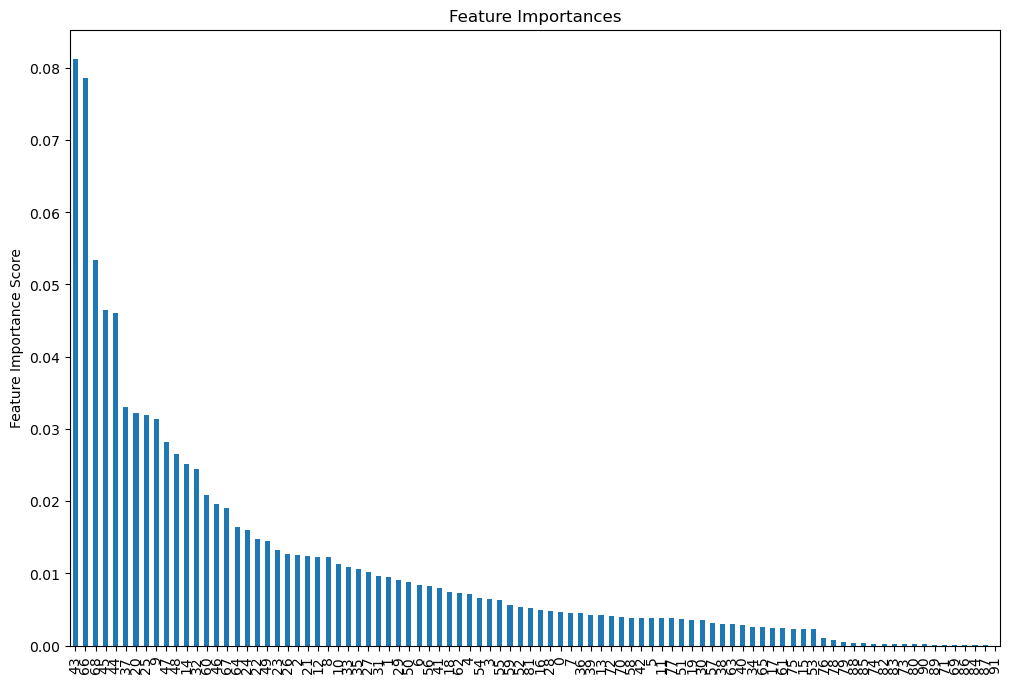

In [ ]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [ ]:
from pathlib import Path
import numpy as np

lithology_numbers = {30000: 0,
                65030: 1,
                65000: 2,
                80000: 3,
                74000: 4,
                70000: 5,
                70032: 6,
                88000: 7,
                86000: 8,
                99000: 9,
                90000: 10,
                93000: 11}
# Set base directory (adjust if needed)
base_dir_N = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

# Map predicted class numbers back to original lithology codes
category_to_lithology = {y: x for x, y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)

# Define full path to save file
filename = "Olawale_Predictions_Actual_Test"
output_file = base_dir_N / f"{filename}.csv"

# Save the prediction file
np.savetxt(output_file, test_prediction_for_submission, header='lithology', fmt='%i', comments='')


In [ ]:
test_targets = pd.read_csv(base_dir /'leaderboard_test_target.csv', sep=';')

In [ ]:
actual_class=test_targets['FORCE_2020_LITHOFACIES_LITHOLOGY'].to_numpy()

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_class, test_prediction_for_submission)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.8012


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_class, test_prediction_for_submission, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.7753


In [ ]:
from sklearn.metrics import confusion_matrix

# Example arrays
actual = actual_class
predicted = test_prediction_for_submission

# Construct confusion matrix
cm = confusion_matrix(actual, predicted)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[19698  3011  1118   105     0     0     4     0    16    96]
 [  669 80359  2175   541     0     0    38     0    30   163]
 [ 2407  9453  5606    68     0     0     1     0    23     0]
 [  534  1376   161  2605     0     0    99     0     0    23]
 [    0     0     0   625     0     0     0     0     0     0]
 [    3   359     6    48     0     0     0     0     0     0]
 [  219  1739   156   885     0     0   307     0     0     0]
 [    0    57     1    51     0     0     0    16     0     0]
 [   60   242    59     0     0     0     0     0   329     0]
 [   97   469     0     3     0     0     0     0     0   676]]


In [ ]:
import numpy as np

unique, counts = np.unique(actual_class, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 24048 samples
Lithology 65000: 83975 samples
Lithology 65030: 17558 samples
Lithology 70000: 4798 samples
Lithology 70032: 625 samples
Lithology 74000: 416 samples
Lithology 80000: 3306 samples
Lithology 86000: 125 samples
Lithology 90000: 690 samples
Lithology 99000: 1245 samples


In [ ]:
import numpy as np

unique, counts = np.unique(test_prediction_for_submission, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 23687 samples
Lithology 65000: 97065 samples
Lithology 65030: 9282 samples
Lithology 70000: 4931 samples
Lithology 80000: 449 samples
Lithology 86000: 16 samples
Lithology 90000: 398 samples
Lithology 99000: 958 samples


In [ ]:
hiddent_test = pd.read_csv(base_dir /'hidden_test.csv', sep=';')

In [ ]:
hidden_targets = hiddent_test['FORCE_2020_LITHOFACIES_LITHOLOGY'].to_numpy()

In [ ]:
return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 14045 samples
Lithology 65000: 71827 samples
Lithology 65030: 12283 samples
Lithology 70000: 8374 samples
Lithology 70032: 2905 samples
Lithology 74000: 287 samples
Lithology 80000: 4396 samples
Lithology 86000: 597 samples
Lithology 88000: 6498 samples
Lithology 90000: 244 samples
Lithology 99000: 941 samples


In [ ]:

# Ensure actual and predicted labels are string-mapped
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Keep label order
ordered_labels = list(lithology_keys.values())

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=ordered_labels)

# Convert to DataFrame for clean display
df_cm = pd.DataFrame(cm, index=ordered_labels, columns=ordered_labels)

# Display
print("Confusion Matrix (Raw Counts):")
df_cm

Confusion Matrix (Raw Counts):


,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Halite,Anhydrite,Tuff,Coals,Basement
Sandstone,11206,1187,1200,214,0,238,0,0,0,0,0,0
Sandstone/Shale,1854,3657,6433,168,0,26,0,0,0,135,10,0
Shale,507,797,68747,1245,0,222,33,12,9,231,24,0
Marl,16,484,1647,1182,0,1000,67,0,0,0,0,0
Dolomite,9,0,153,1,1,7,0,2,114,0,0,0
Limestone,588,123,1097,1016,4,5267,214,0,28,37,0,0
Chalk,146,0,1,7,0,1744,1007,0,0,0,0,0
Halite,1,0,21,0,2,4,0,6463,7,0,0,0
Anhydrite,20,0,4,0,6,42,0,61,464,0,0,0
Tuff,6,0,236,0,0,10,0,0,0,689,0,0


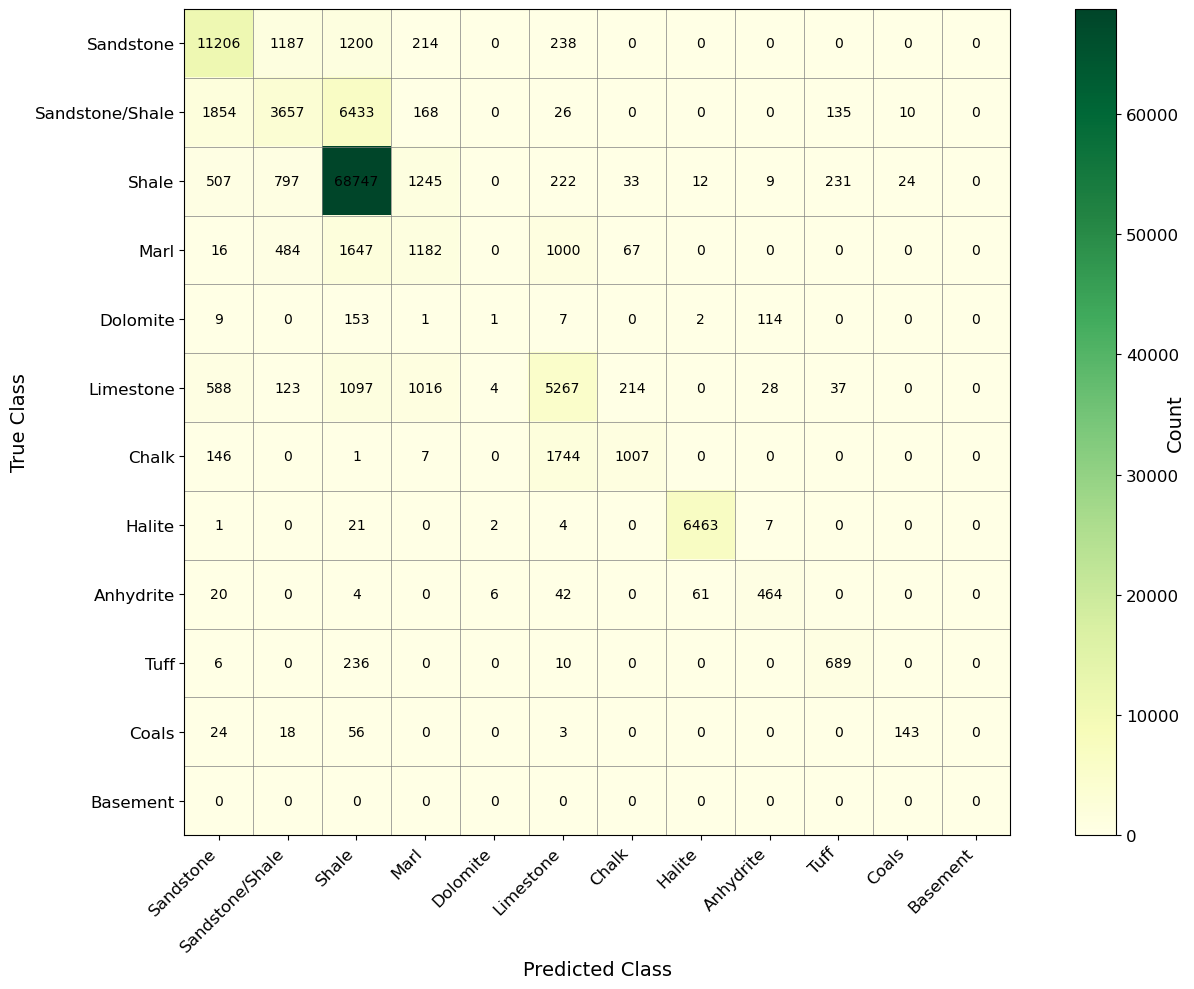

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
data = df_cm.values
row_labels = df_cm.index.tolist()
col_labels = df_cm.columns.tolist()

fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.YlGn  # Use the same colormap
im = ax.imshow(data, cmap=cmap)

# Add colorbar (gradient legend)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=90, va="bottom", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Show ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(row_labels, fontsize=12)

# Gridlines
ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate cells with counts
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=10)

# Titles and labels
#ax.set_title("Confusion Matrix of XGBoost with Data Augmentation", fontsize=16, pad=20)
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_xgboost_augmented.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Map numeric predictions/actuals to strings
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Ensure consistent label order
ordered_labels = list(lithology_keys.values())

# Generate report
report = classification_report(actual_labels, predicted_labels, labels=ordered_labels, zero_division=0)

# Print
print("Classification Report:\n")
print(report)


Classification Report:

                 precision    recall  f1-score   support

      Sandstone       0.78      0.80      0.79     14045
Sandstone/Shale       0.58      0.30      0.39     12283
          Shale       0.86      0.96      0.91     71827
           Marl       0.31      0.27      0.29      4396
       Dolomite       0.08      0.00      0.01       287
      Limestone       0.62      0.63      0.62      8374
          Chalk       0.76      0.35      0.48      2905
         Halite       0.99      0.99      0.99      6498
      Anhydrite       0.75      0.78      0.76       597
           Tuff       0.63      0.73      0.68       941
          Coals       0.81      0.59      0.68       244
       Basement       0.00      0.00      0.00         0

      micro avg       0.81      0.81      0.81    122397
      macro avg       0.60      0.53      0.55    122397
   weighted avg       0.79      0.81      0.79    122397



In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have your true and predicted values
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8074


# Final Scoring FORCE METRIC

In [ ]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
# Map using vectorized approach
y_true = np.vectorize(lithology_numbers.get)(actual)
y_true

array([2, 2, 2, ..., 0, 0, 0])

In [ ]:
custom_score = score(y_true, prediction)
custom_score

-0.5151980100302662